In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

metric = 'auc_relaxed'

dataset = 'kws'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [3]:
files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}_samples{{}}_{intersection}_{{}}.tsv',
    f'{base_path}/{metric}_LR_{{}}_samples{{}}_{intersection}_{{}}.tsv',
    f'{base_path}/{metric}_RF_{{}}_samples{{}}_{intersection}_{{}}.tsv',
]

# names = ["zeros", 'noise_0.01', 'noise_0.05','noise_0.1', 'noise_0.5', 'noise_1']
names = ['zeros', 'noise']
samples = [100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10000, 12000, 14000, 18000]
methods = ['SHAP', 'LR', 'RF']
error_margins = [0, 0.05, 0.06, 0.07, 0.08, 0.09]
df_combinations = []

for method, file_template in zip(methods, files_auc_complete):
    for name, n_sample, error_margin in itertools.product(names, samples, error_margins):
        file_path = file_template.format(name, n_sample, error_margin)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combination['n_sample'] = n_sample
            df_combination['error_margin'] = error_margin
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [4]:
resumen = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()
resumen

,method,name,n_sample,error_margin,roc_auc
0,LR,noise,100,0.00,0.925207
1,LR,noise,100,0.05,0.906137
2,LR,noise,100,0.06,0.891390
3,LR,noise,100,0.07,0.886808
4,LR,noise,100,0.08,0.869095
...,...,...,...,...,...
571,SHAP,zeros,18000,0.05,0.990317
572,SHAP,zeros,18000,0.06,0.985629
573,SHAP,zeros,18000,0.07,0.984975
574,SHAP,zeros,18000,0.08,0.980463


Veamos primero que, para todos explicadores, la curva del AUC cuando error_margin = 0 es mayor que para cualquier error_margin != 0. Nos acercamos a experimentar para el Teorema 1.


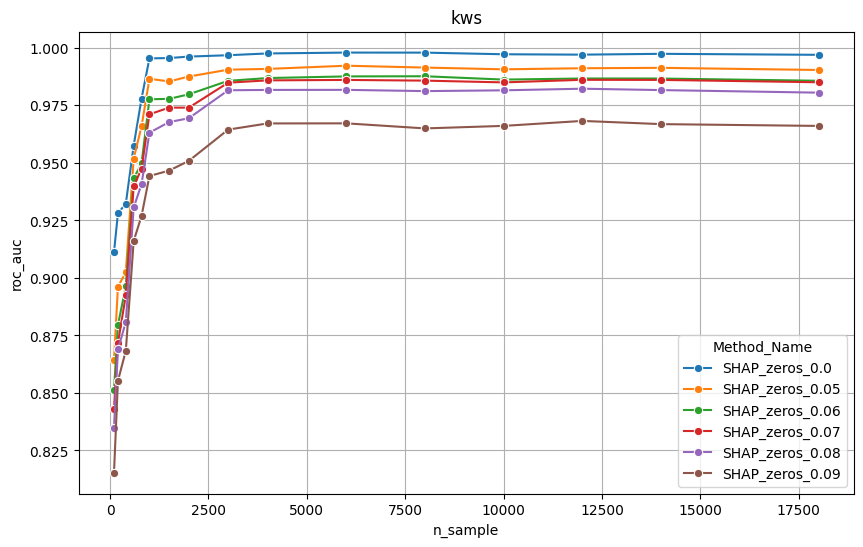

In [17]:
mean_auc_df_combination = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()
mean_auc_df_combination = mean_auc_df_combination[(mean_auc_df_combination['method'] == "SHAP") & (mean_auc_df_combination['name'] == "zeros")]
mean_auc_df_combination = pd.DataFrame(mean_auc_df_combination) 

# Create a grouping column combining method and name
mean_auc_df_combination["group"] = mean_auc_df_combination["method"] + "_" + mean_auc_df_combination["name"] + "_" + mean_auc_df_combination["error_margin"].astype(str)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_auc_df_combination, x="n_sample", y="roc_auc", hue="group", marker="o")
plt.title(dataset)
plt.xlabel("n_sample")
plt.ylabel("roc_auc")
plt.legend(title="Method_Name")
plt.grid(True)
plt.show()

¿Se cumple el Teorema 2? Dado dos explicadores evaluados con error_margin se cumple que se mantiene el ranking cuando los evaluamos antes el GT real? (error_margin = 0)

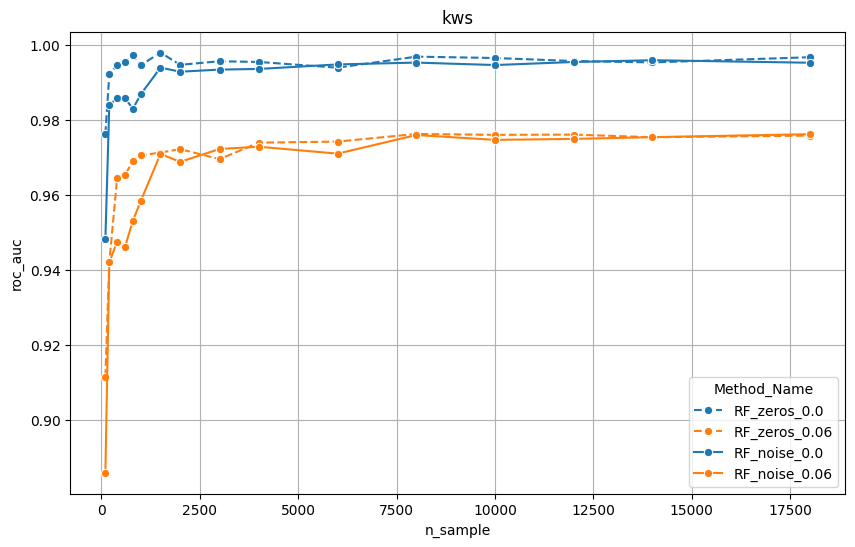

In [30]:
method1 = "RF"
name1 = "zeros"

method2 = "RF"
name2 = "noise"
margin = 0.06

mean_auc_df_combination = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()

mean_auc_df_combination_1 = mean_auc_df_combination[(mean_auc_df_combination['method'] == method1) & (mean_auc_df_combination['name'] == name1)]
mean_auc_df_combination_1 = mean_auc_df_combination_1[(mean_auc_df_combination_1['error_margin'] == margin) | (mean_auc_df_combination_1['error_margin'] == 0)]
mean_auc_df_combination_1 = pd.DataFrame(mean_auc_df_combination_1) 

mean_auc_df_combination_2 = mean_auc_df_combination[(mean_auc_df_combination['method'] == method2) & (mean_auc_df_combination['name'] == name2)]
mean_auc_df_combination_2 = mean_auc_df_combination_2[(mean_auc_df_combination_2['error_margin'] == margin) | (mean_auc_df_combination_2['error_margin'] == 0)]
mean_auc_df_combination_2 = pd.DataFrame(mean_auc_df_combination_2) 

# Create a grouping column combining method and name
mean_auc_df_combination_1["group"] = mean_auc_df_combination_1["method"] + "_" + mean_auc_df_combination_1["name"] + "_" + mean_auc_df_combination_1["error_margin"].astype(str)
mean_auc_df_combination_2["group"] = mean_auc_df_combination_2["method"] + "_" + mean_auc_df_combination_2["name"] + "_" + mean_auc_df_combination_2["error_margin"].astype(str)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_auc_df_combination_1, x="n_sample", y="roc_auc", hue="group", marker="o", linestyle='--')
sns.lineplot(data=mean_auc_df_combination_2, x="n_sample", y="roc_auc", hue="group", marker="o")

plt.title(dataset)
plt.xlabel("n_sample")
plt.ylabel("roc_auc")
plt.legend(title="Method_Name")
plt.grid(True)
plt.show()